In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from praatio import tgio
import os
import matplotlib.pyplot as plot

from scipy.io import wavfile


import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps

import os

from Signal_Analysis.features import signal


from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier


import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

import math



def print_stats(duration_mp):

    duration_ls = [(y, x) for (x, y) in duration_mp.items()]

    duration_ls.sort()

    duration_ls.reverse()

    for labelStat in duration_ls:
        print("Label " + labelStat[1] + " ; Total duration: " + str(round(labelStat[0], 2)) + " seconds")
        
        
        
        
        
##VAD using short term energy

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
 
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    orig_energy = energy
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return orig_energy, energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()



def extract_features(soundData, samplingFrequency):

    soundData = np.array(soundData, dtype="float")
       #--------Energy----------------
    energy = librosa.feature.rms(y=soundData)
        #------melspectogram----------
#     mel_spectrum = librosa.feature.melspectrogram(y=soundData, sr=samplingFrequency, center=False, 
#                                                   n_mels=40,hop_length=hopLength)
        #-------MFCC------------------
#     mfcc= librosa.feature.mfcc(y=soundData,sr=samplingFrequency, n_mfcc=13, hop_length=hopLength)
        #--------Spec Centroid---------
    spec_centr = librosa.feature.spectral_centroid(y=soundData)
        #--------Spec_bandwidth--------
    spec_bandwidth = librosa.feature.spectral_bandwidth(y = soundData)
        #--------Spec_contrast---------
    spec_contrast = librosa.feature.spectral_contrast(y = soundData)
        #------Spec Rolloff--------------
    spec_rolloff = librosa.feature.spectral_rolloff(y=soundData, roll_percent=0.90)
        #------Tonal Centroid------------
    #tonal_centroid = librosa.feature.tonnetz(y=t['data'], sr=t['FS'])
        #------ZCR---------------------
    zcr = librosa.zero_crossings(y=soundData)
    zcr = (np.nonzero(zcr)[0].shape[0])
    print ("zcr", zcr)
    
    ##Other Features
    
    fourier_transform = np.fft.rfft(soundData)
    
    print(soundData)

    abs_fourier_transform = np.abs(fourier_transform)

    power_spectrum = np.square(abs_fourier_transform)
    
#     print(fourier_transform)

    frequency = np.linspace(0, samplingFrequency/2, len(power_spectrum))
    
    ##Calculate the features for cough
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        
        if frequency[i]>0 and frequency[i]<=8000:
            low_sp += power_spectrum[i]
        elif frequency[i]>8000:
            high_sp += power_spectrum[i]

    mean_power = sum(power_spectrum)/len(power_spectrum) 
    power_below16 = low_sp
    power_above16 = high_sp
#     print(power_spectrum)
    
    ##Speech features
    ##Calculate the ratio of (base + first harmonic energy) to total energy
    max_power = max(power_spectrum)
    print(max_power)
    print(np.argmax(power_spectrum))
    base_frequency = frequency[np.argmax(power_spectrum)]
    print (f"Maximum power is {max_power} at frequency {base_frequency}")
    first_harmonic_frequency = 2*base_frequency

    if first_harmonic_frequency not in frequency.tolist():
        first_harmonic_frequency = min(frequency.tolist(),key=lambda x:abs(x-first_harmonic_frequency))
          
    power_at_harmonic = power_spectrum[frequency.tolist().index(first_harmonic_frequency)]
    print (f"Power at first harmonic is {power_at_harmonic} at frequency {first_harmonic_frequency}")
    power_ratio = (max_power+power_at_harmonic)/sum(power_spectrum)
    
    ##VAD
    
    STenergy, energy2, vad, voiced = naive_frame_energy_vad(soundData, samplingFrequency, threshold=-35,
                                                     win_len=1, win_hop=1)
    
    
    ##Mask features
    ##energy ratio between 0–1 and 1–8 kHz (LH1000)
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        if frequency[i]>0 and frequency[i]<=1000:
            low_sp += power_spectrum[i]
        elif frequency[i]>1000 and frequency[i]<=25000:
            high_sp += power_spectrum[i]
            
    print ("Energy in 0 Hz - 1 kHz", low_sp)
    print ("Energy in 1 kHz - 8 kHz", high_sp)
    print ("energy ratio between 0–1 and 1–8 kHz (LH1000)", low_sp/high_sp)
    LH_ratio = low_sp/high_sp
    
    ## HNR
    
    HNR = signal.get_HNR( soundData, samplingFrequency )
    
## index - feature
#     0 - energy      
#     1 - mel_spectrum (40, 12)
#     2 - mfcc (13, 16)
#     3 - spec_centr (1, 12)
#     4 - spec_bandwidth (1, 12)
#     5 - spec_contrast (7, 12)
#     6 - spec_rolloff (1, 12)
#     7 - zcr 
#     8 - mean_power  
#     9 - power_below16
#     10 - power_above16
#     11 - base_frequency
#     12 - power_ratio
#     13 - STenergy
#     14 - LH_ratio
#     15 - HNR
#     features = [np.average(energy), mel_spectrum, mfcc, spec_centr, spec_bandwidth, spec_contrast, spec_rolloff, zcr, mean_power,power_below16,power_above16, base_frequency, power_ratio, STenergy[0], LH_ratio, HNR] 
    features = [np.average(energy), spec_centr[0][0], spec_bandwidth[0][0],  spec_rolloff[0][0], zcr, mean_power, power_below16, power_above16, base_frequency, power_ratio, STenergy[0], LH_ratio, HNR] 

    
    selected_features = []
#     for index in indices:
#         selected_features.append(features[index])

    non_privacy_features = abs_fourier_transform
    
    return features,selected_features,non_privacy_features

In [3]:
var = pd.read_csv('AIM_exp1_editted.csv')
var = var[25:]
var.head()

,Sample #,Start Date,Start Time,Sample Length,Averaging Interval (s),Title,Instrument ID,Instrument Errors,Conc Mean,Conc Min,Conc Max,Conc Std Dev
25,26,06/06/22,14:17:14,10,1,NaN,3775 71025228 2.16,None,0.8859,0.000,1.969,0.624020
26,27,06/06/22,14:17:25,10,1,NaN,3775 71025228 2.16,None,0.2364,0.000,0.788,0.229740
27,28,06/06/22,14:17:36,10,1,NaN,3775 71025228 2.16,None,0.1969,0.000,0.394,0.152467
28,29,06/06/22,14:17:47,10,1,NaN,3775 71025228 2.16,None,0.0197,0.000,0.197,0.059100
29,30,06/06/22,14:17:58,10,1,NaN,3775 71025228 2.16,None,0.5513,0.394,0.984,0.211748


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_15679/61590351.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10, axis='x')


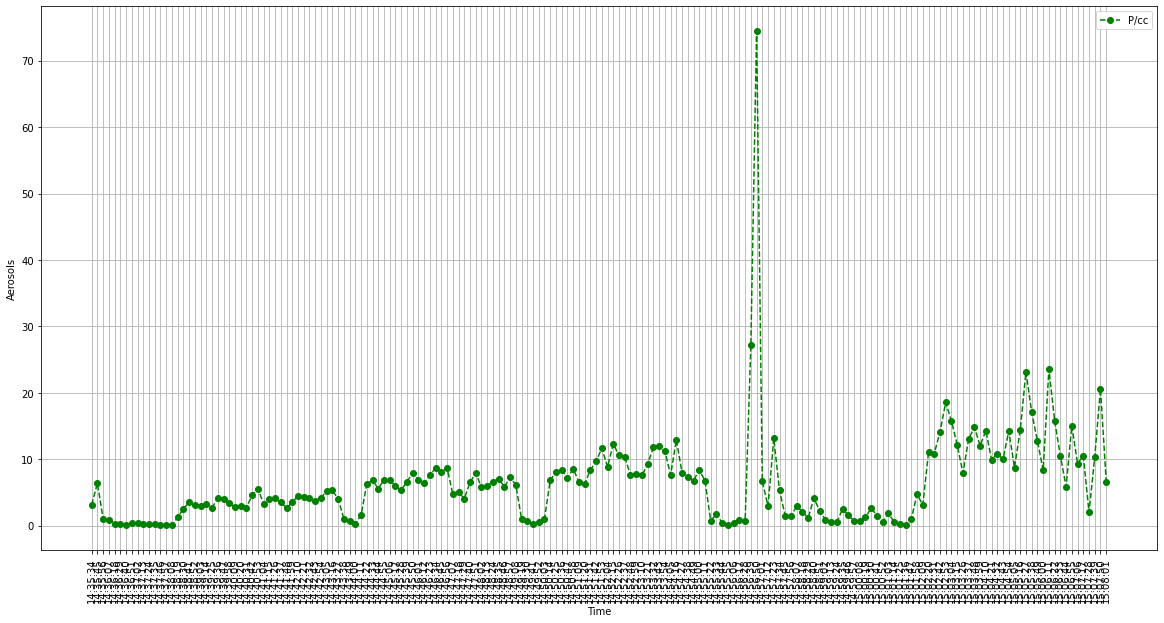

In [4]:
x = var['Start Time'][100:]
y = var['Conc Mean'][100:]

plt.figure(figsize=(20,10))
plt.plot(x, y , color = 'g', linestyle = 'dashed',
         marker = 'o',label = "P/cc")


plt.locator_params(nbins=10, axis='x')
plt.xticks(rotation = 90)
plt.xlabel('Time')
plt.ylabel('Aerosols')

plt.grid()
plt.legend()
plt.show()

In [5]:
y

125     3.16720
126     6.39260
127     1.04290
128     0.88570
129     0.23640
         ...   
298    10.52350
299     2.00630
300    10.38770
301    20.62260
302     6.59125
Name: Conc Mean, Length: 178, dtype: float64

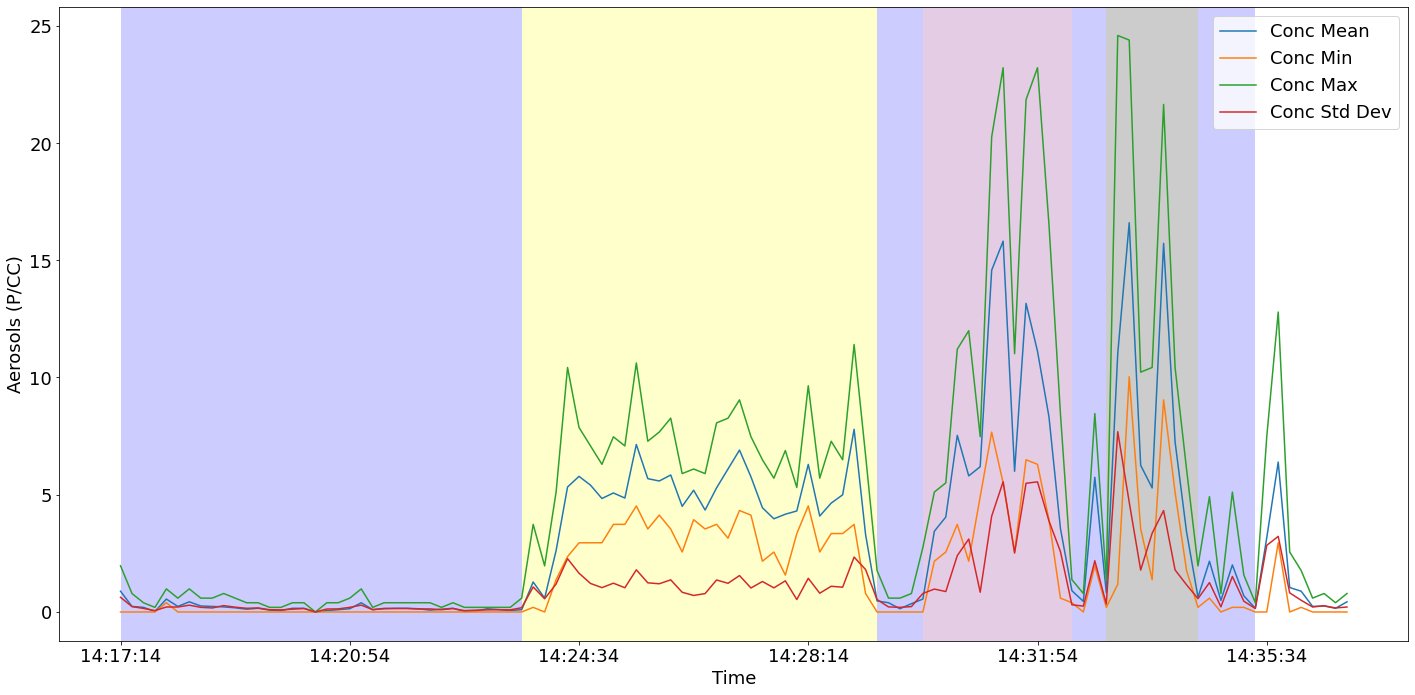

In [6]:

df = var[:108]
df_type = df
df = df.drop('Sample #', 1)
df = df.drop('Sample Length', 1)
df = df.drop('Averaging Interval (s)', 1)
df = df.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 35 , color='blue', alpha=0.2, lw=0)
plt.axvspan(35, 66 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(66, 70 , color='blue', alpha=0.2, lw=0)
plt.axvspan(70, 83 , color='purple', alpha=0.2, lw=0)
plt.axvspan(83, 86 , color='blue', alpha=0.2, lw=0)
plt.axvspan(86, 94 , color='black', alpha=0.2, lw=0)
plt.axvspan(94, 99 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_type.jpg')

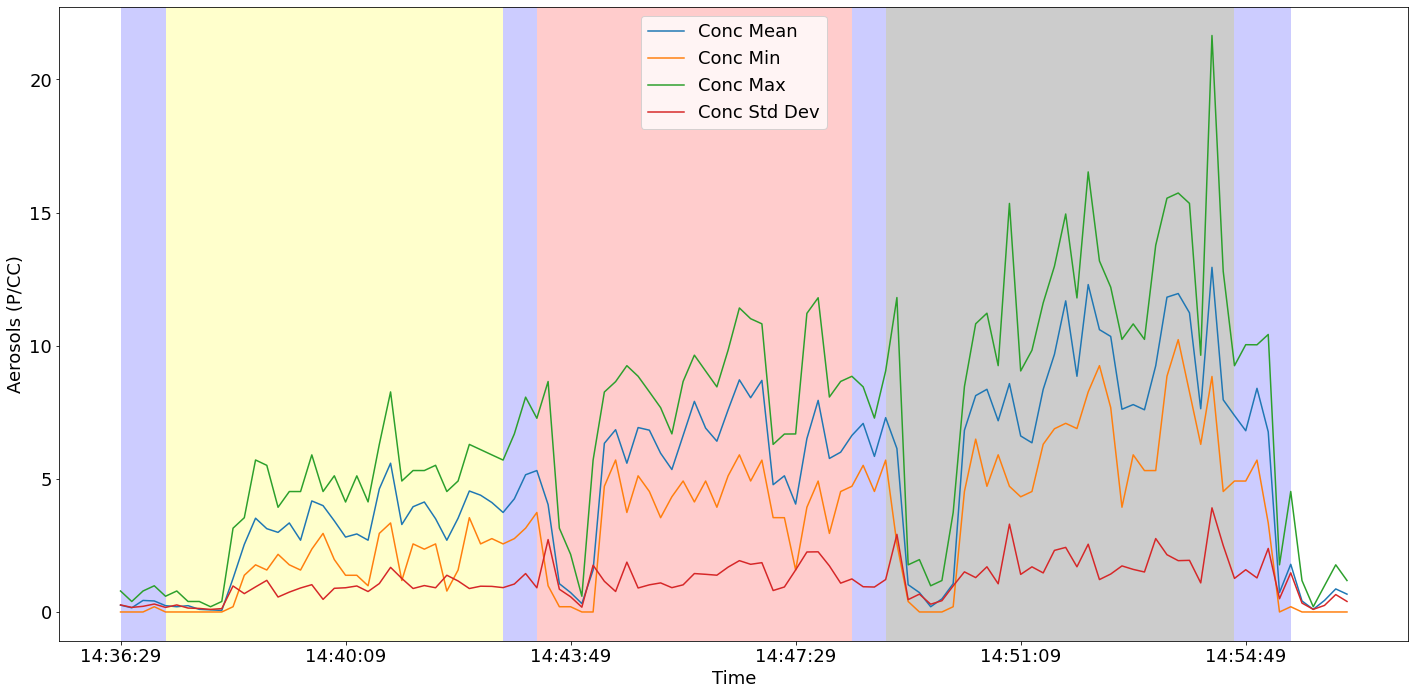

In [7]:


df2 = var[105:215]
df_level = df2
df2 = df2.drop('Sample #', 1)
df2 = df2.drop('Sample Length', 1)
df2 = df2.drop('Averaging Interval (s)', 1)
df2 = df2.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df2.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 4 , color='blue', alpha=0.2, lw=0)
plt.axvspan(4, 34 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(34, 37 , color='blue', alpha=0.2, lw=0)
plt.axvspan(37, 65 , color='red', alpha=0.2, lw=0)
plt.axvspan(65, 68 , color='blue', alpha=0.2, lw=0)
plt.axvspan(68, 99 , color='black', alpha=0.2, lw=0)
plt.axvspan(99, 104 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_level.jpg')

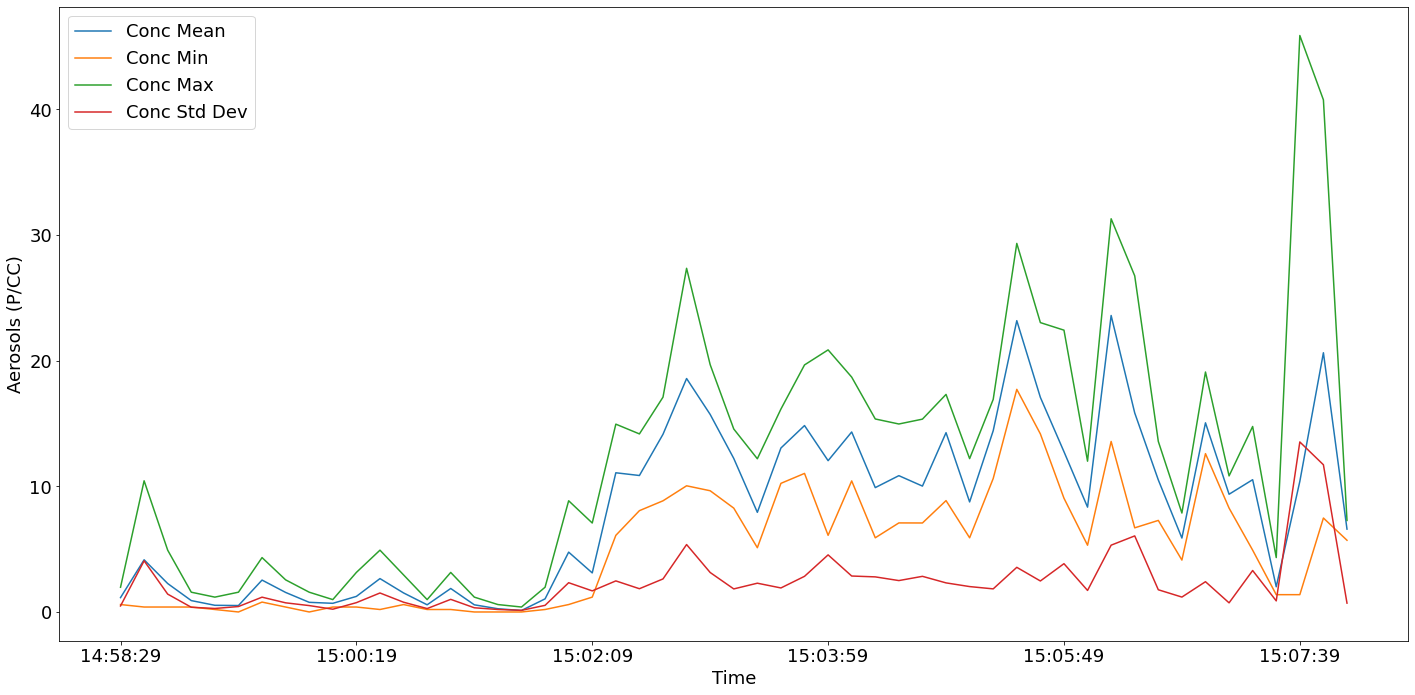

In [8]:

df3 = var[225:]
df3 = df3.drop('Sample #', 1)
df3 = df3.drop('Sample Length', 1)
df3 = df3.drop('Averaging Interval (s)', 1)
df3 = df3.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df3.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

# plt.axvspan(0, 106 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(106, 151 , color='yellow', alpha=0.2, lw=0)
# plt.axvspan(151, 160 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(160, 221 , color='red', alpha=0.2, lw=0)
# plt.axvspan(221, 237 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(237, 294 , color='black', alpha=0.2, lw=0)
# plt.axvspan(294, 306 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_graph.jpg')

In [9]:
import matplotlib.pyplot as plot

from scipy.io import wavfile

import statistics 
import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps
import math
import os

from Signal_Analysis.features import signal



# Read the wav file (mono)
def wav_plot(filename, m,n):
    WAV_FILE_NAME  = filename
    samplingFrequency, signalData = wavfile.read(WAV_FILE_NAME)
    
#     signalData = signalData[m:n]
    times = np.arange(len(signalData))/samplingFrequency
    print (len(times), times[-1])

    
    print(samplingFrequency)
    numchunks = 10
    chunks = np.array_split(signalData, numchunks)
    dbs = [20*math.log10( math.sqrt(statistics.mean(chunk**2)) ) for chunk in chunks]
    print ("average power", dbs)
    
    
    plt.figure(figsize=(20,7))

    # Plot the signal read from wav file

    plot.subplot(311)

    plot.title('Spectrogram of a wav file with air')



    plot.plot(times,signalData)

    plot.xlabel('Sample')

    plot.ylabel('Amplitude')



    plot.subplot(312)

    plot.specgram(signalData,Fs=samplingFrequency)

    plot.xlabel('Time')

    plot.ylabel('Frequency')
    

    plot.show()
    
    return samplingFrequency, signalData

zcr 5240
[-693. -846. -904. ... 1701. 1930. 2111.]
4.6361760407315014e+17
1199
Maximum power is 4.6361760407315014e+17 at frequency 119.9949960385305
Power at first harmonic is 1377210343794881.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1646323470290819e+18
Energy in 1 kHz - 8 kHz 1.0052811296978272e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.85140838952715
zcr 5025
[2270. 2414. 2575. ... 2266. 2095. 1872.]
3.983142621658808e+17
1199
Maximum power is 3.983142621658808e+17 at frequency 119.9949960385305
Power at first harmonic is 300608955473476.4 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1670322551352225e+18
Energy in 1 kHz - 8 kHz 9833546158068228.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.67867769936646
zcr 5100
[ 1641.  1429.  1202. ... -7519. -7351. -7202.]
3.500717910332682e+17
1199
Maximum power is 3.500717910332682e+17 at frequency 119.9949960385305
Power at first harmonic is 271875057251504.25 at frequency 239.989992077061
Energy in

Energy in 0 Hz - 1 kHz 1.4423375189225638e+18
Energy in 1 kHz - 8 kHz 3.6153584312798776e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.89473094682787
zcr 7282
[-2292. -2470. -2626. ...  1694.  1843.  1879.]
3.076359888557217e+17
1199
Maximum power is 3.076359888557217e+17 at frequency 119.9949960385305
Power at first harmonic is 780860808582695.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4413307327843988e+18
Energy in 1 kHz - 8 kHz 3.368136249831068e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.793124323776695
zcr 7524
[ 1831.  1755.  1597. ... -1620. -1694. -1839.]
3.7334919616501037e+17
1199
Maximum power is 3.7334919616501037e+17 at frequency 119.9949960385305
Power at first harmonic is 2264567039964862.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.5317945520864402e+18
Energy in 1 kHz - 8 kHz 4.171399651892474e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.721356856600835
zcr 7125
[-1996. -2154. -2311. ... -1764. -1811. -1789.]
4.469219806

zcr 5218
[-3194. -3222. -3151. ...  5325.  5283.  5181.]
3.5047423545286637e+17
1199
Maximum power is 3.5047423545286637e+17 at frequency 119.9949960385305
Power at first harmonic is 680943968926723.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1214138348996177e+18
Energy in 1 kHz - 8 kHz 9970675018804614.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.47120508738276
zcr 9043
[5097. 5064. 4975. ... 2082. 2019. 1959.]
2.5581375703228746e+17
1199
Maximum power is 2.5581375703228746e+17 at frequency 119.9949960385305
Power at first harmonic is 480947627654842.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.6330212427044178e+18
Energy in 1 kHz - 8 kHz 8.243882748563794e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.80888487271261
zcr 9130
[ 1954.  2035.  2169. ... -6146. -6593. -7022.]
3.1722069098961574e+17
1199
Maximum power is 3.1722069098961574e+17 at frequency 119.9949960385305
Power at first harmonic is 346525577849262.3 at frequency 239.989992077061
Ene

Energy in 0 Hz - 1 kHz 1.8852470513946982e+18
Energy in 1 kHz - 8 kHz 1.2381837323881371e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.2259071257425
zcr 9012
[ 2835.  2731.  2690. ... -5428. -3830. -2058.]
2.2944935188865146e+17
1199
Maximum power is 2.2944935188865146e+17 at frequency 119.9949960385305
Power at first harmonic is 294629401218.3342 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.208570164215994e+18
Energy in 1 kHz - 8 kHz 1.9123553056847062e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.54895305098772
zcr 11257
[-2709. -4063. -3819. ...  -554.  -414.  -287.]
3.39350329237051e+17
1199
Maximum power is 3.39350329237051e+17 at frequency 119.9949960385305
Power at first harmonic is 19229714439708.742 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.2911315726302193e+18
Energy in 1 kHz - 8 kHz 1.917055932464567e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.951302691960274
zcr 10766
[-154.  -22.   85. ...  473.  684.  816.]
4.701971205354601e+

zcr 12683
[-10383. -10748. -10990. ...    860.    271.   -112.]
4.335702208650373e+17
1199
Maximum power is 4.335702208650373e+17 at frequency 119.9949960385305
Power at first harmonic is 1209937004654871.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.7888688883271014e+18
Energy in 1 kHz - 8 kHz 2.008982248540726e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.881998660530053
zcr 12003
[ 1372.   809. -3261. ...  7980.  7837.  7805.]
4.018320766062154e+17
1199
Maximum power is 4.018320766062154e+17 at frequency 119.9949960385305
Power at first harmonic is 536804679067758.9 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.8332231915366687e+18
Energy in 1 kHz - 8 kHz 3.109970008677397e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.11013027016803
zcr 12789
[7980. 8101. 8050. ...  583.  640.  709.]
4.646645573893847e+17
1199
Maximum power is 4.646645573893847e+17 at frequency 119.9949960385305
Power at first harmonic is 1509919081846892.8 at frequency 239.989992077

Energy in 0 Hz - 1 kHz 2.5242919773080253e+18
Energy in 1 kHz - 8 kHz 1.922262293355658e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.131881044711205
zcr 12394
[  759.  1310.  1949. ... -8067. -8042. -7943.]
4.719460157227414e+17
1199
Maximum power is 4.719460157227414e+17 at frequency 119.99549641589766
Power at first harmonic is 1475353186309172.8 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 2.5565540848825293e+18
Energy in 1 kHz - 8 kHz 1.843009620749617e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.871626366457537
zcr 10592
[-7871. -7697. -7319. ...  3000.  3001.  2942.]
4.617594838898191e+17
1199
Maximum power is 4.617594838898191e+17 at frequency 119.99549641589766
Power at first harmonic is 1611640113850334.5 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.180807581583849e+18
Energy in 1 kHz - 8 kHz 2.483978182399195e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.805295972896223
zcr 6779
[2725. 2463. 2254. ... 1828. 1918. 2094.]
4.664414438

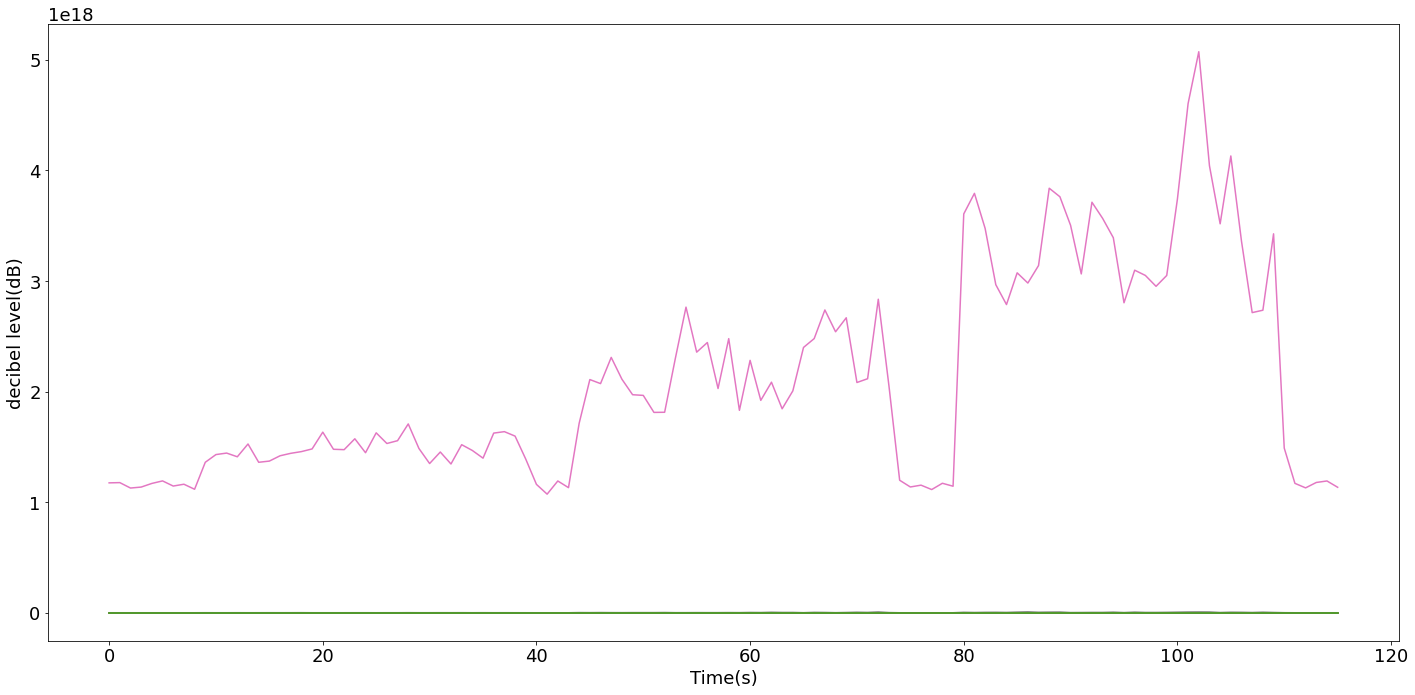

In [10]:
from scipy.io.wavfile import read
samprate, wavdata = read('0606_exp_actlevel.wav')
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs1 = []
WIDTH = 2

chunks = np.array_split(wavdata, 116)
for chunk in chunks:
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs1.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs1)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_actlevel.png")

zcr 5104
[-1622. -1486. -1302. ...  3605.  3362.  3200.]
4.760531120581478e+17
1197
Maximum power is 4.760531120581478e+17 at frequency 119.99147930180396
Power at first harmonic is 2576278690465810.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1915516846388114e+18
Energy in 1 kHz - 8 kHz 9898305238449814.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.37936353086458
zcr 4998
[ 3057.  2954.  2955. ... -1181. -1216. -1234.]
4.475240426609729e+17
1197
Maximum power is 4.475240426609729e+17 at frequency 119.99147930180396
Power at first harmonic is 1478577712678259.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1294272960986455e+18
Energy in 1 kHz - 8 kHz 9767670903914570.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.62913075275777
zcr 5314
[-1321. -1407. -1560. ...  1295.  1513.  1750.]
4.0267252883647366e+17
1197
Maximum power is 4.0267252883647366e+17 at frequency 119.99147930180396
Power at first harmonic is 1131767443293409.0 at frequency 239.982958

Energy in 0 Hz - 1 kHz 1.1626281576977917e+18
Energy in 1 kHz - 8 kHz 9587812243939096.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.2610476840265
zcr 5132
[ 4958.  5149.  5317. ... -5952. -5864. -5825.]
3.594527964301601e+17
1197
Maximum power is 3.594527964301601e+17 at frequency 119.99147930180396
Power at first harmonic is 522328496971200.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1429029804775226e+18
Energy in 1 kHz - 8 kHz 9724724427387998.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.5254876383679
zcr 5152
[-5890. -6015. -6078. ...  2556.  2609.  2668.]
3.308220902843086e+17
1197
Maximum power is 3.308220902843086e+17 at frequency 119.99147930180396
Power at first harmonic is 187887949658907.38 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1364118040243726e+18
Energy in 1 kHz - 8 kHz 9512884651653618.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.46027368542
zcr 5195
[2687. 2626. 2548. ... 1193. 1088. 1056.]
3.6482790237361766e+17
1197

zcr 10433
[2575. 2625. 2631. ... 1335. 1520. 1687.]
3.775323906393312e+17
1197
Maximum power is 3.775323906393312e+17 at frequency 119.99147930180396
Power at first harmonic is 1158210932589183.8 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.2851604884243366e+18
Energy in 1 kHz - 8 kHz 1.29021665646604e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.71144773997486
zcr 9468
[ 1755.  1677.  1541. ... -2887. -3248. -3465.]
3.156304004095978e+17
1197
Maximum power is 3.156304004095978e+17 at frequency 119.99147930180396
Power at first harmonic is 405503055529030.25 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.9838218978232584e+18
Energy in 1 kHz - 8 kHz 8.368102342358021e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.70695071188916
zcr 10558
[-3614. -3864. -4217. ...  1164.   948.   692.]
4.031723563385214e+17
1197
Maximum power is 4.031723563385214e+17 at frequency 119.99147930180396
Power at first harmonic is 1232177893111370.2 at frequency 239.982958603

Energy in 0 Hz - 1 kHz 2.7104499369684265e+18
Energy in 1 kHz - 8 kHz 1.5724537576501997e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.237072465767096
zcr 10290
[3662. 3645. 3710. ... -184. -274. -447.]
3.7484530493245075e+17
1197
Maximum power is 3.7484530493245075e+17 at frequency 119.99147930180396
Power at first harmonic is 367678553857955.7 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.4400403889934735e+18
Energy in 1 kHz - 8 kHz 1.2627911365388024e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.322596733466202
zcr 8116
[ -720.  -970. -1199. ...  4836.  4804.  4756.]
4.643726786052188e+17
1197
Maximum power is 4.643726786052188e+17 at frequency 119.99147930180396
Power at first harmonic is 2161473286037199.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.8953333995459822e+18
Energy in 1 kHz - 8 kHz 1.0112043298526618e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.74332757081987
zcr 5195
[4594. 4399. 4256. ...  922. 1099. 1222.]
3.588168487243

zcr 5134
[ 798.  732.  700. ... -861. -763. -717.]
4.3227182206917997e+17
1197
Maximum power is 4.3227182206917997e+17 at frequency 119.9919804858489
Power at first harmonic is 1620754604656863.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1217425065229879e+18
Energy in 1 kHz - 8 kHz 9827836706302102.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.13931061793795
zcr 5179
[ -698.  -680.  -669. ... -1059. -1087. -1096.]
3.881615784756343e+17
1197
Maximum power is 3.881615784756343e+17 at frequency 119.9919804858489
Power at first harmonic is 603937515672847.2 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1461932522004628e+18
Energy in 1 kHz - 8 kHz 9880081896508444.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.01050114832752
zcr 5159
[-1066. -1097. -1137. ... -2893. -3022. -3073.]
4.307203175888492e+17
1197
Maximum power is 4.307203175888492e+17 at frequency 119.9919804858489
Power at first harmonic is 1316868437256750.8 at frequency 239.9839609716978
Ener

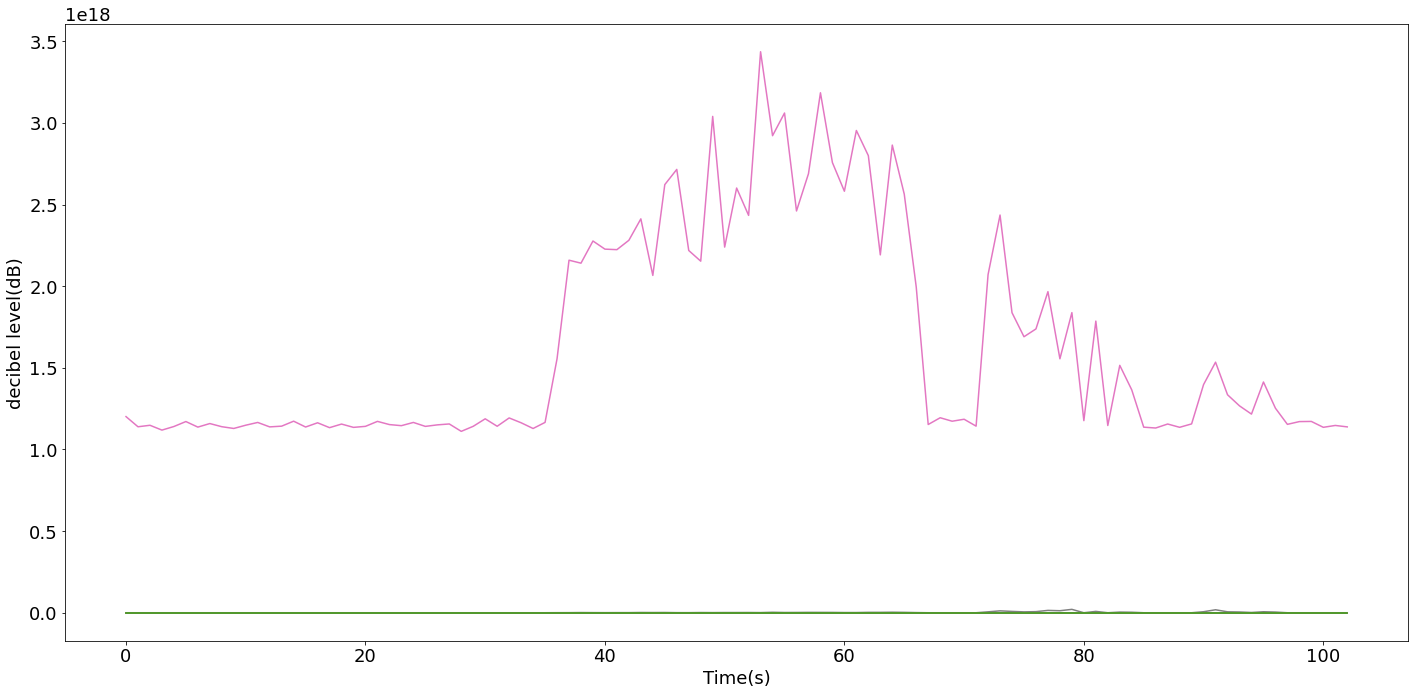

In [11]:
from scipy.io.wavfile import read
samprate, wavdata = read('0606_exp_activtype.wav')
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs2 = []
WIDTH = 2

chunks = np.array_split(wavdata, 103)
for chunk in chunks:
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs2.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs2)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_activtype.png")
print(len(dbs2))

210
zcr 5851
[-152. -180. -210. ...  -98. -124. -147.]
4510784780712634.0
721
Maximum power is 4510784780712634.0 at frequency 120.040790559899
Power at first harmonic is 89249280771257.23 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.8834009366656424e+16
Energy in 1 kHz - 8 kHz 1278929824237204.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.82156867575691
zcr 5900
[-137.  -99.  -68. ...  857.  875.  969.]
4607608041828092.0
721
Maximum power is 4607608041828092.0 at frequency 120.040790559899
Power at first harmonic is 33546153966762.316 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.265509821193741e+16
Energy in 1 kHz - 8 kHz 910297025059291.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.82929031637387
zcr 5478
[  861.   695.   793. ...  -914. -1274. -1529.]
5190198509155697.0
721
Maximum power is 5190198509155697.0 at frequency 120.040790559899
Power at first harmonic is 215716589501822.03 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.95014815559647

Energy in 0 Hz - 1 kHz 1.3713265395595611e+17
Energy in 1 kHz - 8 kHz 6443135077184104.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.283529262262235
zcr 6089
[1667. 1675. 1625. ...  439.  396.  351.]
3577851922980969.0
721
Maximum power is 3577851922980969.0 at frequency 120.040790559899
Power at first harmonic is 13900710242742.498 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.4286807098805931e+17
Energy in 1 kHz - 8 kHz 3127548978818094.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.68052233735102
zcr 5370
[ 300.  210.   98. ... -886. -800. -727.]
3940264159179830.5
721
Maximum power is 3940264159179830.5 at frequency 120.040790559899
Power at first harmonic is 55664839521102.53 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.4211047670106474e+17
Energy in 1 kHz - 8 kHz 2706931913975318.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.49872594407652
zcr 5482
[-663. -580. -511. ...  736.  765.  789.]
3505327061282779.5
721
Maximum power is 3505327061282779.5

zcr 5885
[-1439. -1229. -1052. ...  -263.  -167.   -85.]
2259344430687819.0
721
Maximum power is 2259344430687819.0 at frequency 120.040790559899
Power at first harmonic is 28510296592122.387 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.1326643875850032e+17
Energy in 1 kHz - 8 kHz 1738742029481348.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.14275081524698
zcr 6128
[    4.   125.   255. ... -2208. -2193. -2123.]
2438245782389375.5
721
Maximum power is 2438245782389375.5 at frequency 120.040790559899
Power at first harmonic is 59367565424956.43 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.0108887947538917e+17
Energy in 1 kHz - 8 kHz 2351490239370557.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.989283043951076
zcr 5480
[-2058. -1997. -1918. ...  3498.  3424.  3333.]
2344107748718652.0
721
Maximum power is 2344107748718652.0 at frequency 120.040790559899
Power at first harmonic is 33449108739277.594 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.149

Energy in 0 Hz - 1 kHz 2.2848900948324493e+17
Energy in 1 kHz - 8 kHz 1.1201819212196342e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.397491260568653
zcr 7705
[ 730.  749.  801. ... 2143. 2191. 2224.]
3565036592005284.0
721
Maximum power is 3565036592005284.0 at frequency 120.040790559899
Power at first harmonic is 16641854639722.508 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.3014192392192934e+17
Energy in 1 kHz - 8 kHz 1.7211467551760182e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.371429439693141
zcr 7821
[2260. 2296. 2313. ... 2542. 2507. 2436.]
3173059183154093.5
721
Maximum power is 3173059183154093.5 at frequency 120.040790559899
Power at first harmonic is 62949208132568.67 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.3813933604891302e+17
Energy in 1 kHz - 8 kHz 9782848241622604.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.34253605567684
zcr 6451
[2375. 2358. 2340. ... 1694. 1714. 1725.]
3084430614840929.5
721
Maximum power is 308443061

zcr 6149
[-1023. -1023. -1015. ...  -492.  -509.  -546.]
3503701853717212.0
721
Maximum power is 3503701853717212.0 at frequency 120.040790559899
Power at first harmonic is 11688849108576.104 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.526320612112844e+17
Energy in 1 kHz - 8 kHz 1.5777032636047658e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.67431992645739
zcr 7237
[-594. -690. -790. ... -450. -491. -521.]
3160031586922346.5
721
Maximum power is 3160031586922346.5 at frequency 120.040790559899
Power at first harmonic is 47057169464979.88 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.347116774391256e+17
Energy in 1 kHz - 8 kHz 8010952016658958.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.298849493922482
zcr 6276
[-549. -610. -711. ... 3824. 4150. 4249.]
2529550734006007.0
721
Maximum power is 2529550734006007.0 at frequency 120.040790559899
Power at first harmonic is 27859169840572.965 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.63843359032424

zcr 7715
[962. 979. 980. ... 229. 334. 430.]
2616044126738377.5
721
Maximum power is 2616044126738377.5 at frequency 120.040790559899
Power at first harmonic is 25869672096648.92 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.5963657476560813e+17
Energy in 1 kHz - 8 kHz 7792139843504676.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.32031765087409
zcr 6350
[  501.   570.   639. ... -1468. -1501. -1549.]
2403110338615908.5
721
Maximum power is 2403110338615908.5 at frequency 120.040790559899
Power at first harmonic is 3059131148987.698 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.951590732547756e+17
Energy in 1 kHz - 8 kHz 8199225326664878.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.80213562616636
zcr 7251
[-1588. -1592. -1573. ... -4104. -4239. -4309.]
2242587366319252.0
721
Maximum power is 2242587366319252.0 at frequency 120.040790559899
Power at first harmonic is 6513036189206.996 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.038545644686363e+17

Energy in 0 Hz - 1 kHz 3.1918186617552772e+16
Energy in 1 kHz - 8 kHz 351526501670943.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.79880596721192
zcr 3855
[ 821.  766.  734. ...  765.  908. 1041.]
3532309751915099.5
721
Maximum power is 3532309751915099.5 at frequency 120.040790559899
Power at first harmonic is 578681113576.3589 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.232763146613884e+16
Energy in 1 kHz - 8 kHz 354244076381048.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.25807210778905
zcr 4058
[ 1115.  1166.  1199. ... -2150. -2154. -2147.]
3796569382872467.5
721
Maximum power is 3796569382872467.5 at frequency 120.040790559899
Power at first harmonic is 9210048324653.266 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.2741142578138944e+16
Energy in 1 kHz - 8 kHz 395416352873872.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.80169077524849
zcr 3733
[-2143. -2148. -2150. ...  -400.  -396.  -419.]
3788779749473113.0
721
Maximum power is 37887797494

zcr 6265
[  -35.   -39.   -66. ... -1975. -1980. -1941.]
3272668463831936.5
721
Maximum power is 3272668463831936.5 at frequency 120.04162330905307
Power at first harmonic is 2101114714757.973 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.3627730150055923e+17
Energy in 1 kHz - 8 kHz 5517517599906725.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.699024340740305
zcr 8334
[-1858. -1776. -1707. ...  2179.  1975.  1739.]
3262712085203754.0
721
Maximum power is 3262712085203754.0 at frequency 120.04162330905307
Power at first harmonic is 7485910733526.2295 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.3270967354753798e+17
Energy in 1 kHz - 8 kHz 6726151877450933.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.730400973019968
zcr 7197
[1551. 1481. 1490. ... 4416. 4570. 4592.]
5074989898200038.0
2948
Maximum power is 5074989898200038.0 at frequency 490.8220603537981
Power at first harmonic is 33711558450101.02 at frequency 981.6441207075962
Energy in 0 Hz - 1 kHz 

zcr 5549
[-1930. -1690. -1439. ... -1352. -1470. -1589.]
3102042624468038.0
721
Maximum power is 3102042624468038.0 at frequency 120.04162330905307
Power at first harmonic is 12848391646400.275 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 8.728440713849864e+16
Energy in 1 kHz - 8 kHz 2403596094000117.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.31409093914694
zcr 6360
[-1685. -1789. -1900. ...   145.   126.   103.]
2846699331393680.0
721
Maximum power is 2846699331393680.0 at frequency 120.04162330905307
Power at first harmonic is 9254534085738.027 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 8.58024647719336e+16
Energy in 1 kHz - 8 kHz 5858488302865381.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.645837003714371
zcr 6122
[   62.     6.   -24. ... -3122. -3114. -3062.]
2665853235780944.0
721
Maximum power is 2665853235780944.0 at frequency 120.04162330905307
Power at first harmonic is 3807533047583.143 at frequency 240.08324661810613
Energy in 0 Hz - 1 k

zcr 5929
[  -14.   152.   311. ... -1460. -1519. -1586.]
1639885413716847.0
721
Maximum power is 1639885413716847.0 at frequency 120.04162330905307
Power at first harmonic is 10791245176577.723 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.3020486807085541e+17
Energy in 1 kHz - 8 kHz 4999194968118513.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.045167052138208
zcr 6155
[-1641. -1661. -1659. ...  -678.  -668.  -654.]
1381337993409636.0
721
Maximum power is 1381337993409636.0 at frequency 120.04162330905307
Power at first harmonic is 25940728967956.39 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.436114976867638e+17
Energy in 1 kHz - 8 kHz 3721272136496166.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.59204390839954
zcr 6455
[-666. -667. -693. ... -284. -286. -267.]
1581367164210712.0
721
Maximum power is 1581367164210712.0 at frequency 120.04162330905307
Power at first harmonic is 19962114768593.227 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 

zcr 3647
[192. 159. 102. ... 654. 626. 591.]
4023982614025032.5
721
Maximum power is 4023982614025032.5 at frequency 120.04162330905307
Power at first harmonic is 17105196289204.945 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.1511430833182596e+16
Energy in 1 kHz - 8 kHz 289631613064788.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.79831279375475
zcr 3528
[  557.   513.   460. ... -1402. -1452. -1475.]
3764875066105922.0
721
Maximum power is 3764875066105922.0 at frequency 120.04162330905307
Power at first harmonic is 7102161026022.114 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.234646397844729e+16
Energy in 1 kHz - 8 kHz 282066111963872.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.67688817077855
zcr 3442
[-1450. -1415. -1393. ...  1249.  1199.  1162.]
4004548719466126.0
721
Maximum power is 4004548719466126.0 at frequency 120.04162330905307
Power at first harmonic is 39217511400659.68 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.19431

zcr 3943
[1283. 1346. 1382. ...  561.  602.  629.]
2964586257797247.5
721
Maximum power is 2964586257797247.5 at frequency 120.04162330905307
Power at first harmonic is 15958237649472.908 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.3031204404844144e+16
Energy in 1 kHz - 8 kHz 332853960813803.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.23632671843622
zcr 3449
[664. 681. 690. ... 731. 787. 839.]
3026125863624564.5
721
Maximum power is 3026125863624564.5 at frequency 120.04162330905307
Power at first harmonic is 8996720571606.254 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.254417154006489e+16
Energy in 1 kHz - 8 kHz 306084958158047.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.32398186408322
zcr 3406
[ 876.  882.  859. ... -198. -146.  -99.]
2457999374180301.5
721
Maximum power is 2457999374180301.5 at frequency 120.04162330905307
Power at first harmonic is 13073341594519.408 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.365352712144197e

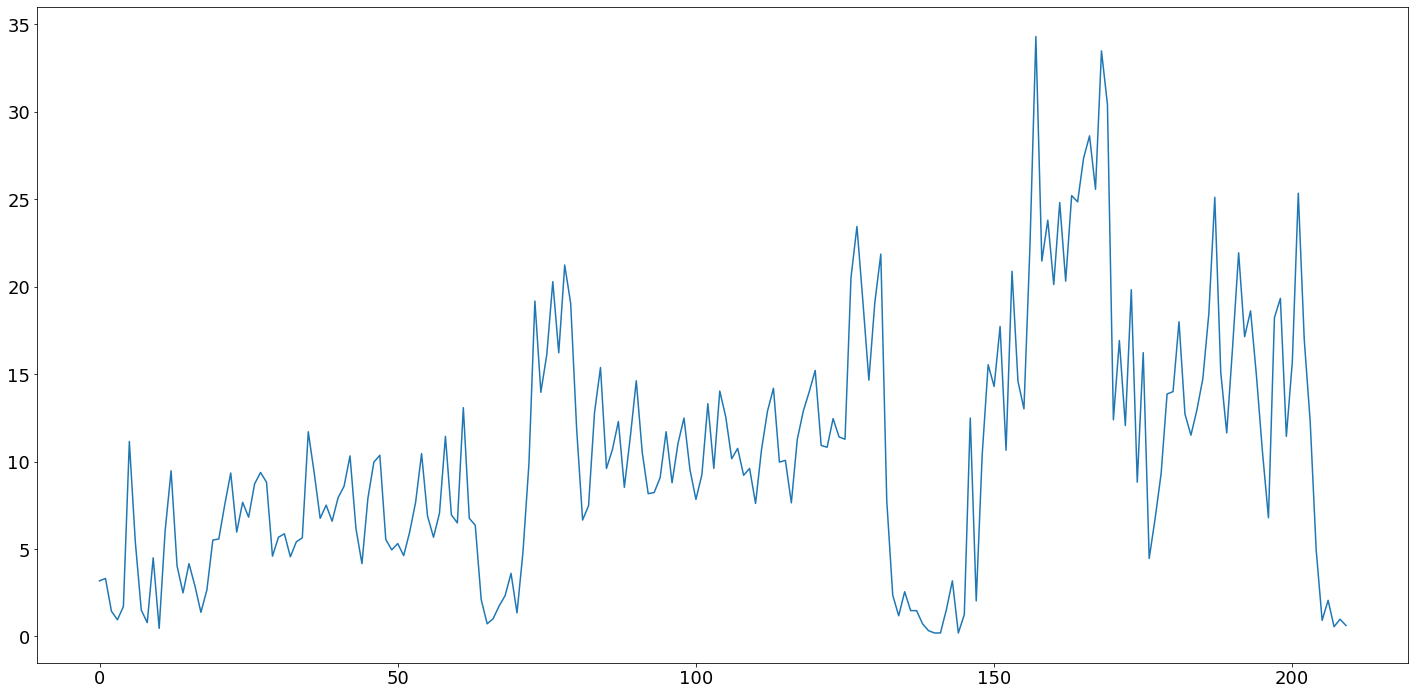

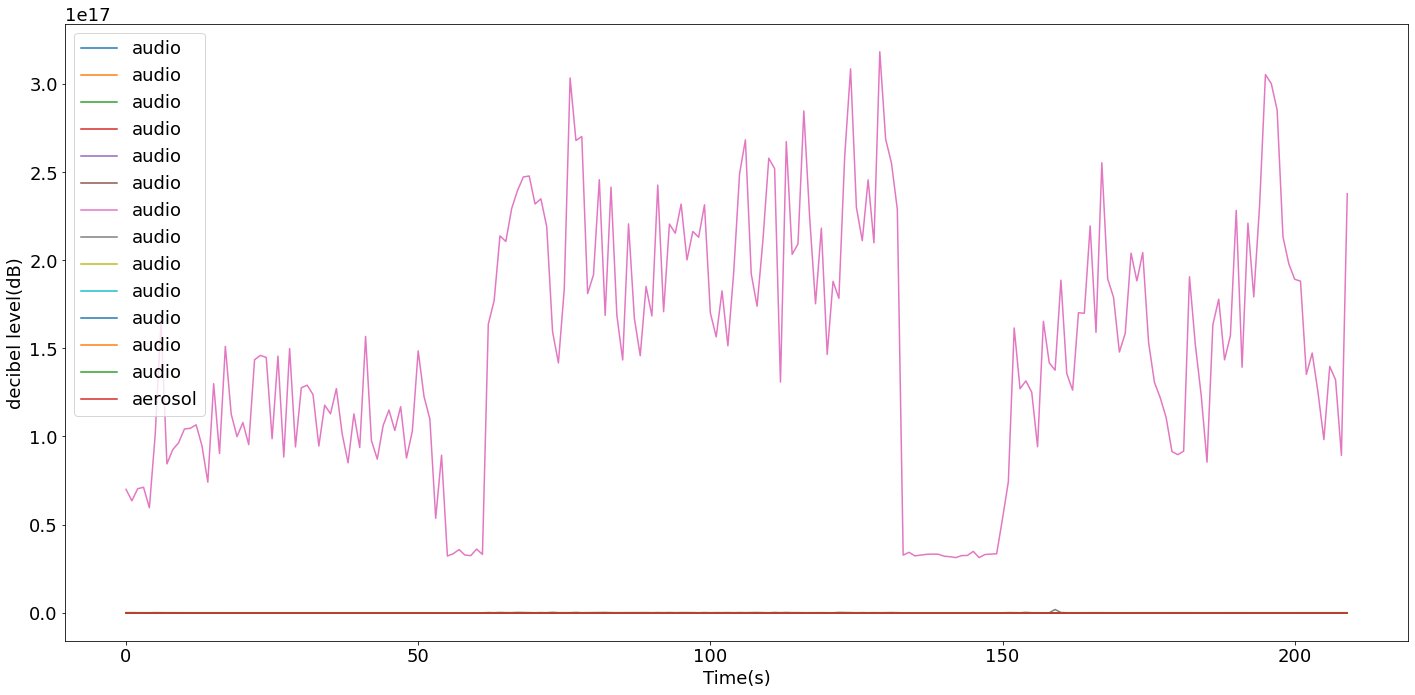

In [12]:
##get data from other file

var = pd.read_csv('exp_0415/mask_test_counting.csv')
df5 = var[85:]
# df4 = df4.drop('Sample #', 1)
# df4 = df4.drop('Sample Length', 1)
# df4 = df4.drop('Averaging Interval (s)', 1)
# df4 = df4.drop('Title', 1)
# df5 = df4[:-12]
df5 = df5.drop(df.index[(df['Start Time'] < "13:52")])
# plt.plot(df5['Conc Mean'])
temp = df5['Conc Mean'].tolist()[125:335]
plt.plot(temp)

print (len(temp))

samprate, wavdata = read('exp_0415/4-15-butanol_exp.wav')

dbs3 = []
WIDTH = 2

chunks = np.array_split(wavdata, 1544/6)
for chunk in chunks:
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs3.append(a)
# print(dbs)
dbs3 = dbs3[:210]

x = range(0,11600)
plt.figure(figsize=(20,10))
print(len(dbs3))

plt.plot(dbs3, label="audio")
plt.plot(temp, label="aerosol")
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_activities_415.png")


In [13]:
print(len(dbs3), len(temp))
print (len(dbs2[1:66]), len(df['Conc Mean'].tolist()[:65]))
print (len(dbs1[:-6]), len(df2['Conc Mean'].tolist()))
db = dbs2[1:66]+ dbs1[:-6] + dbs3[:145]
print(len(db))

df_temp = df['Conc Mean'].tolist()[:65] + df2['Conc Mean'].tolist() + temp[:145]

print(len(df_temp))

210 210
65 65
110 110
320
320


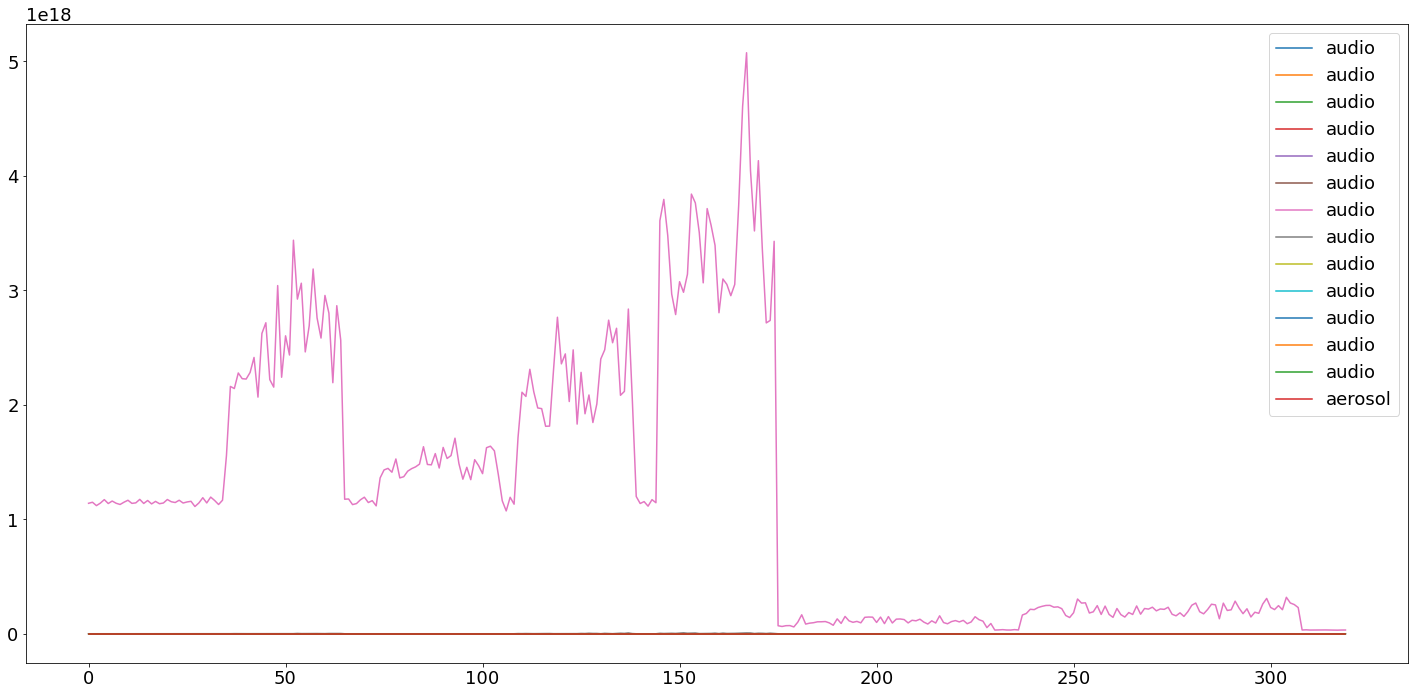

In [14]:
plt.plot(db, label="audio")
plt.plot(df_temp, label="aerosol")
plt.legend()



Train Mean Squared Error: 1.3185133637400568
Regression score:  0.859944783838163
Mean Absolute Error: 2.122197898961505
Mean Squared Error: 10.414285311426463
Root Mean Squared Error: 3.2271171827850416


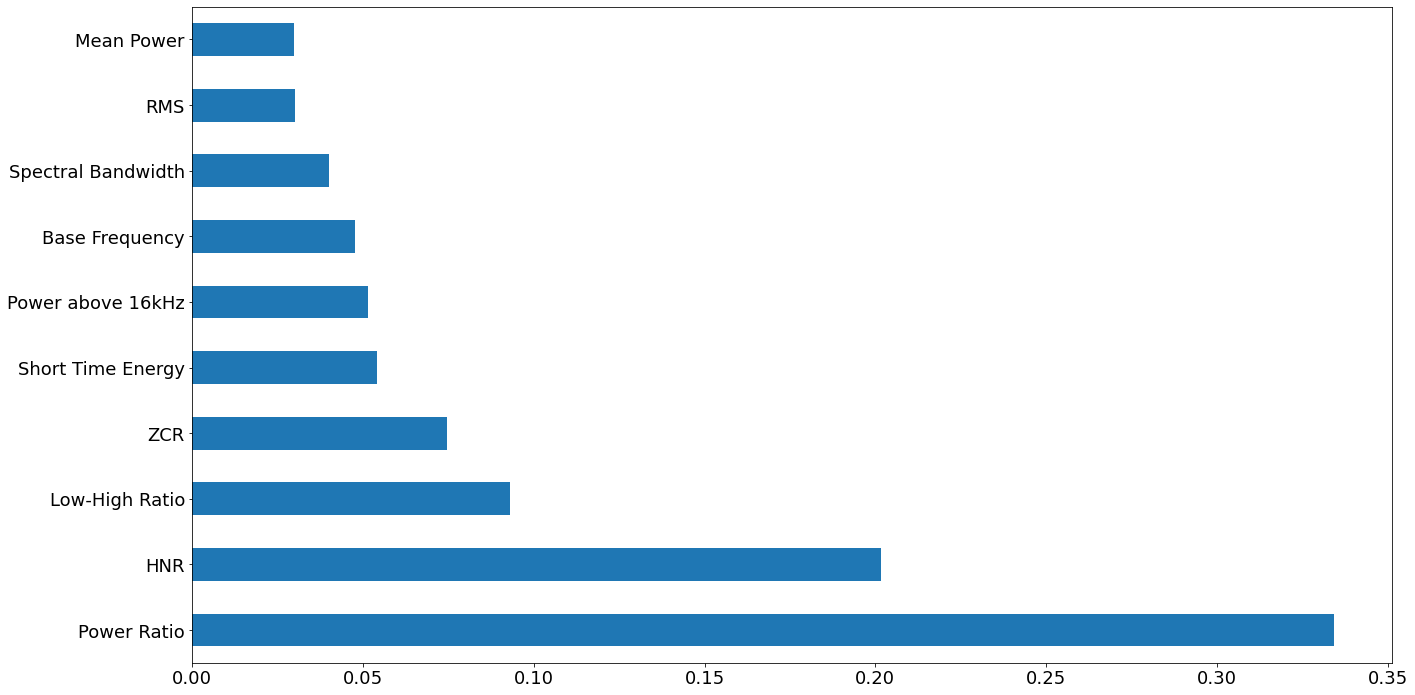

In [15]:
X = np.array(db)
y = np.array(df_temp)

from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(X_train, y_train)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



import pandas as pd
columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 
feat_importances = pd.Series(reg.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))



print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Train Mean Squared Error: 12.257162031654971
Regression score:  0.454768459242204
Mean Absolute Error: 2.584430000875197
Mean Squared Error: 12.04567207323036
Root Mean Squared Error: 3.470687550504995


In [17]:
from sklearn import svm

regr = svm.SVR(kernel='rbf', C=1, epsilon=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Train Mean Squared Error: 17.727626971058513
Regression score:  0.22488671785492242
Mean Absolute Error: 3.074180472936479
Mean Squared Error: 15.914103764406082
Root Mean Squared Error: 3.9892485212638835


(64, 13)

In [18]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Train Mean Squared Error: 4.47080936793314
Regression score:  0.7571439776112743
Mean Absolute Error: 1.9823750085482716
Mean Squared Error: 9.32037304063114
Root Mean Squared Error: 3.052928600644165


(64, 13)

Train Mean Squared Error: 9.027796614315168e-36
Regression score:  0.8134940349287754
Mean Absolute Error: 3.253474265625
Mean Squared Error: 20.891537224920143
Root Mean Squared Error: 4.570726115719486


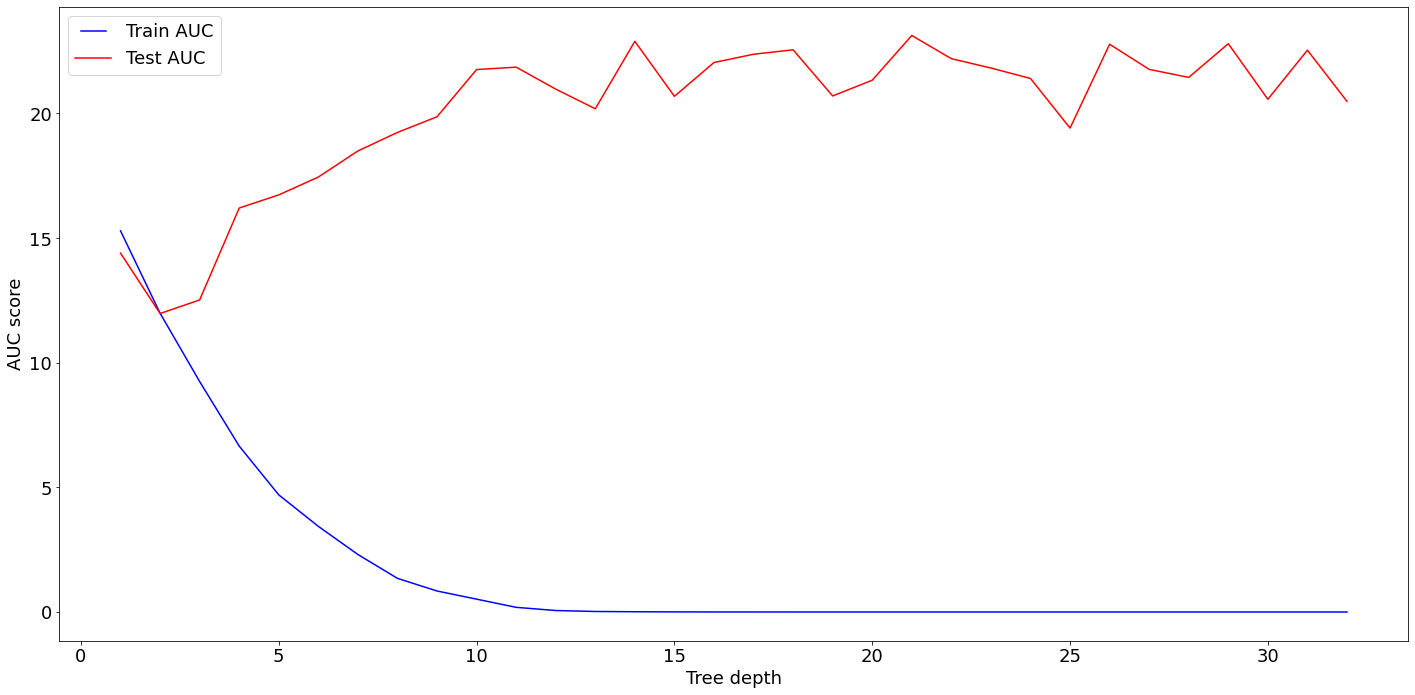

In [19]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))




print ("Regression score: ", clf.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


x_train = X_train
x_test = X_test
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   train_results.append(metrics.mean_squared_error(train_pred, y_train))
   y_pred = dt.predict(x_test)
   test_results.append(metrics.mean_squared_error(y_pred, y_test))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()



In [20]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.5, link='log')

reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X.shape

Train Mean Squared Error: 22.42885323971315
Regression score:  -0.00020211752549625928
Mean Absolute Error: 3.8005483447265633
Mean Squared Error: 22.324746931814985
Root Mean Squared Error: 4.724907081818116


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)


(320, 13)

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=250)
model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


[0.06880961 0.03185419 0.0372484  0.02911224 0.06391537 0.07133252
 0.0688465  0.05373296 0.04076472 0.15722889 0.0492403  0.08975957
 0.23815471]
Train Mean Squared Error: 6.167472846830203e-28
Regression score:  0.9210156562473203
Mean Absolute Error: 1.9575083288125001
Mean Squared Error: 8.847461565450947
Root Mean Squared Error: 2.9744682828113915


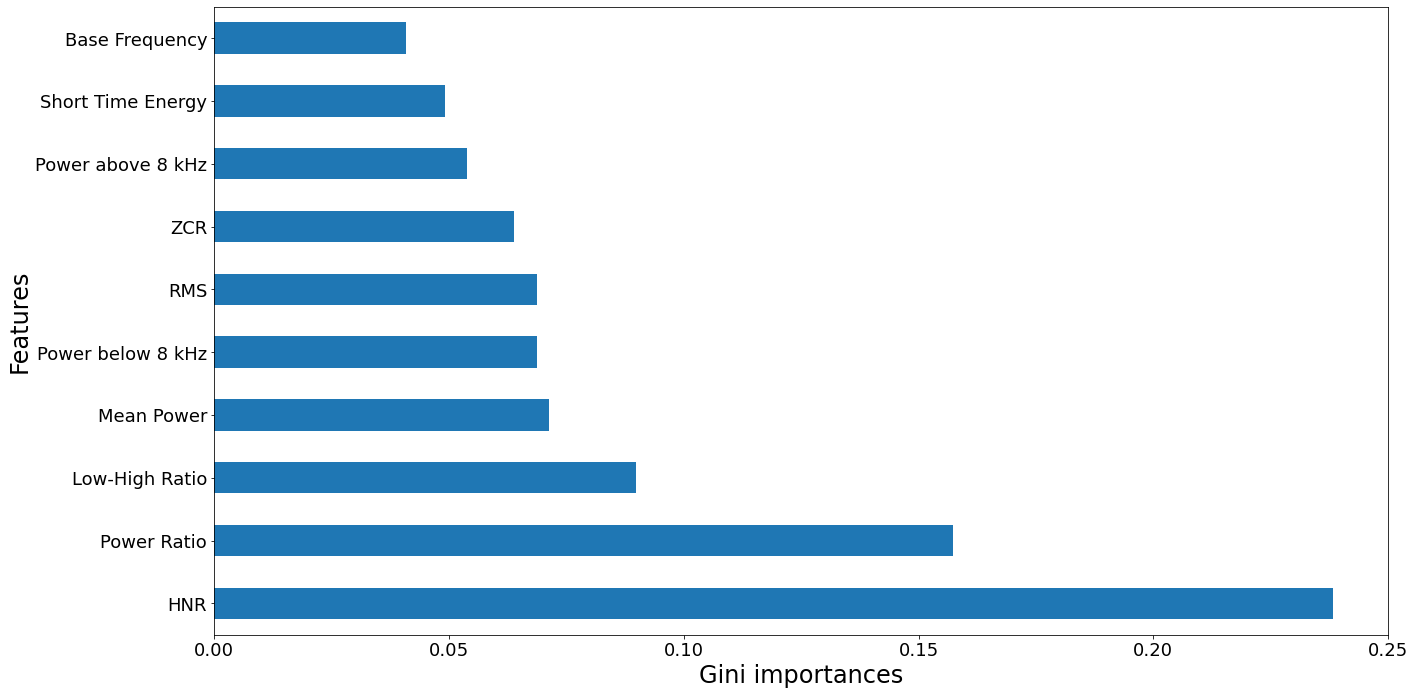

In [22]:
import pandas as pd
columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 8 kHz", "Power above 8 kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 
feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

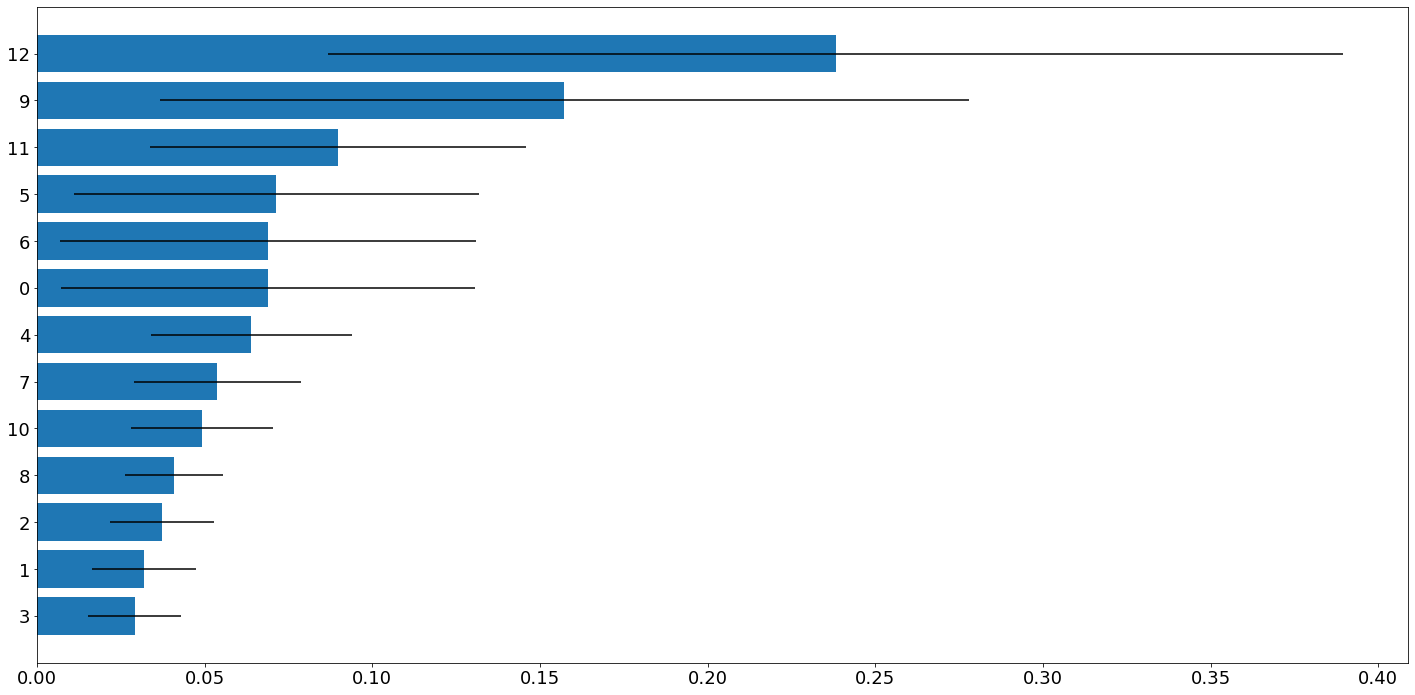

In [23]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=columns)
indices = np.argsort(importances)
plt.figure()
plt.barh(range(X.shape[1]), importances[indices], xerr=std[indices], align="center")
# ax.set_title("Feature importances using MDI")
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

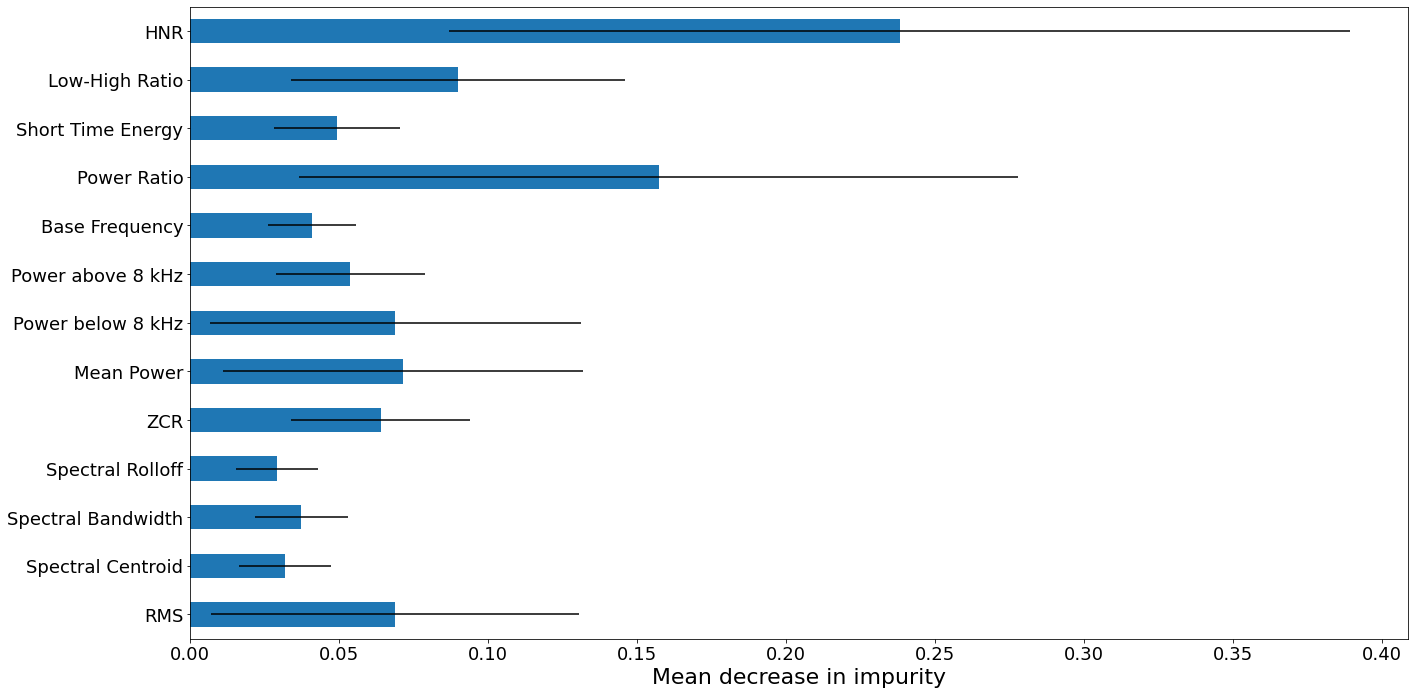

In [24]:
forest_importances = pd.Series(importances, index=columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity", fontsize=22)
fig.tight_layout()

Elapsed time to compute the importances: 1.344 seconds


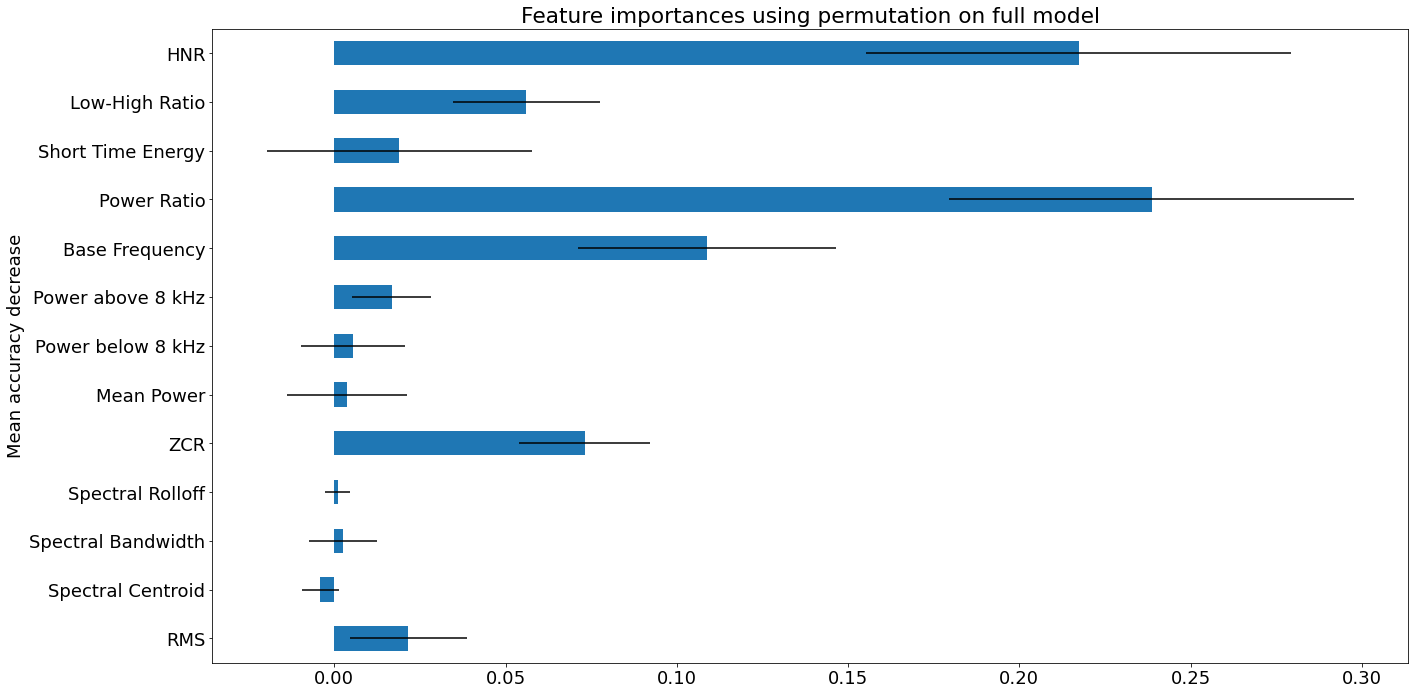

In [25]:
 from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

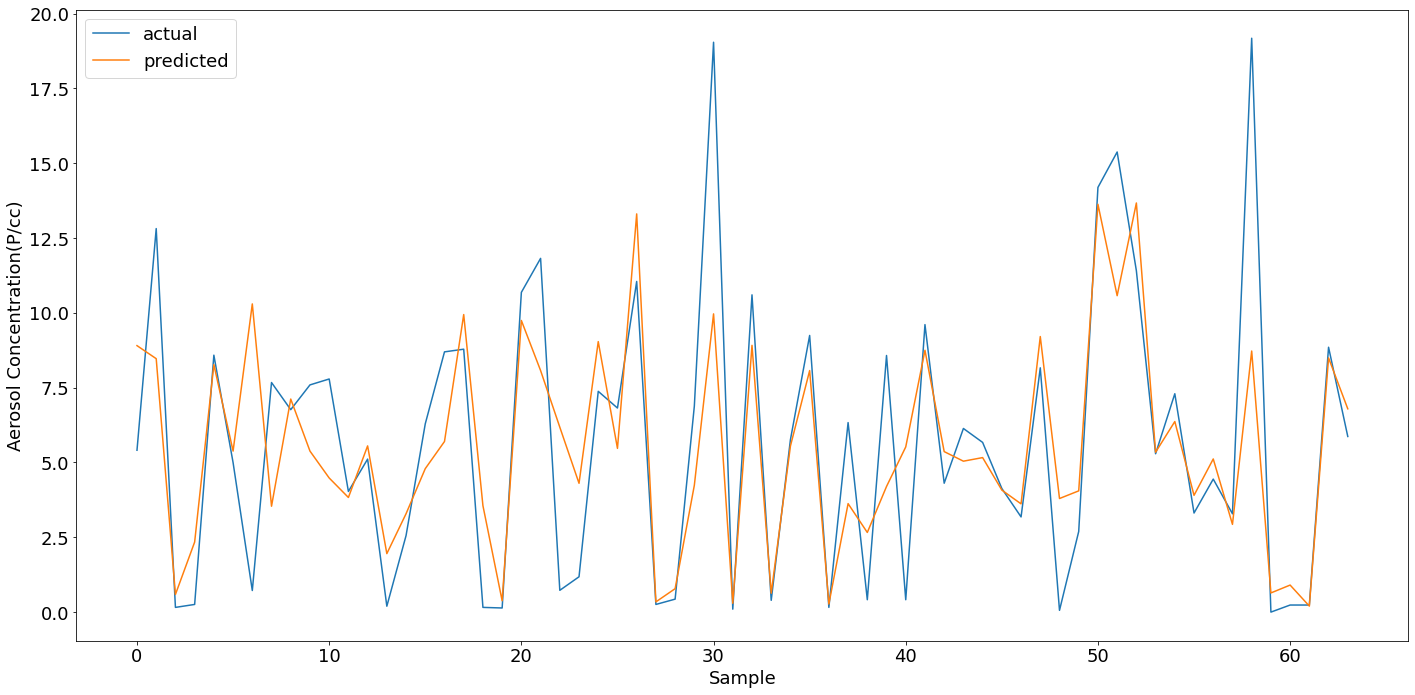

In [26]:
plt.plot(y_test, label="actual")
plt.plot(y_pred, label="predicted")
plt.ylabel("Aerosol Concentration(P/cc)")
plt.xlabel("Sample")
plt.legend()
plt.savefig("aerosol_predictions_GB.png")

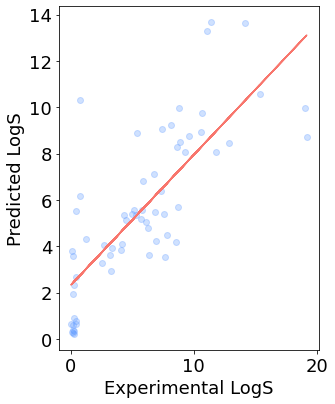

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,11))

plt.subplot(2, 1, 2)
plt.scatter(x=y_test, y=y_pred, c="#619CFF", alpha=0.3)

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

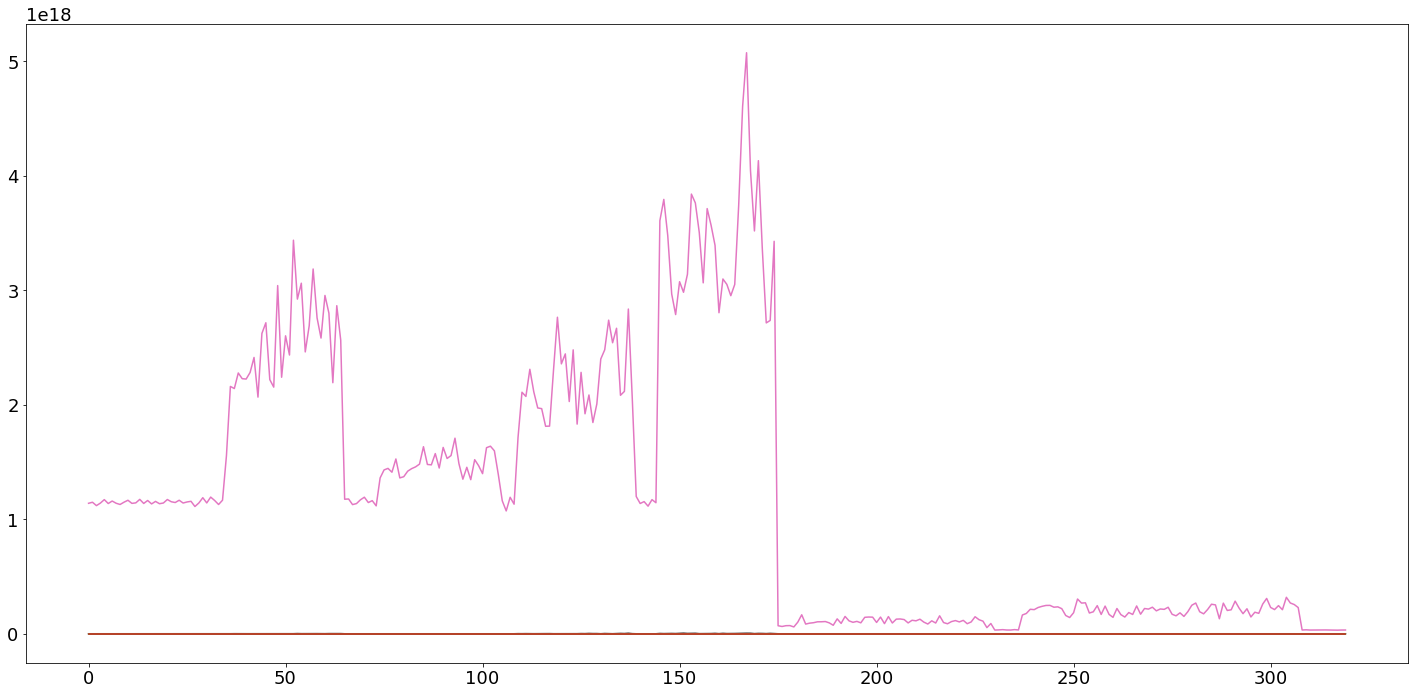

In [28]:
plt.plot(X)
plt.plot(y)

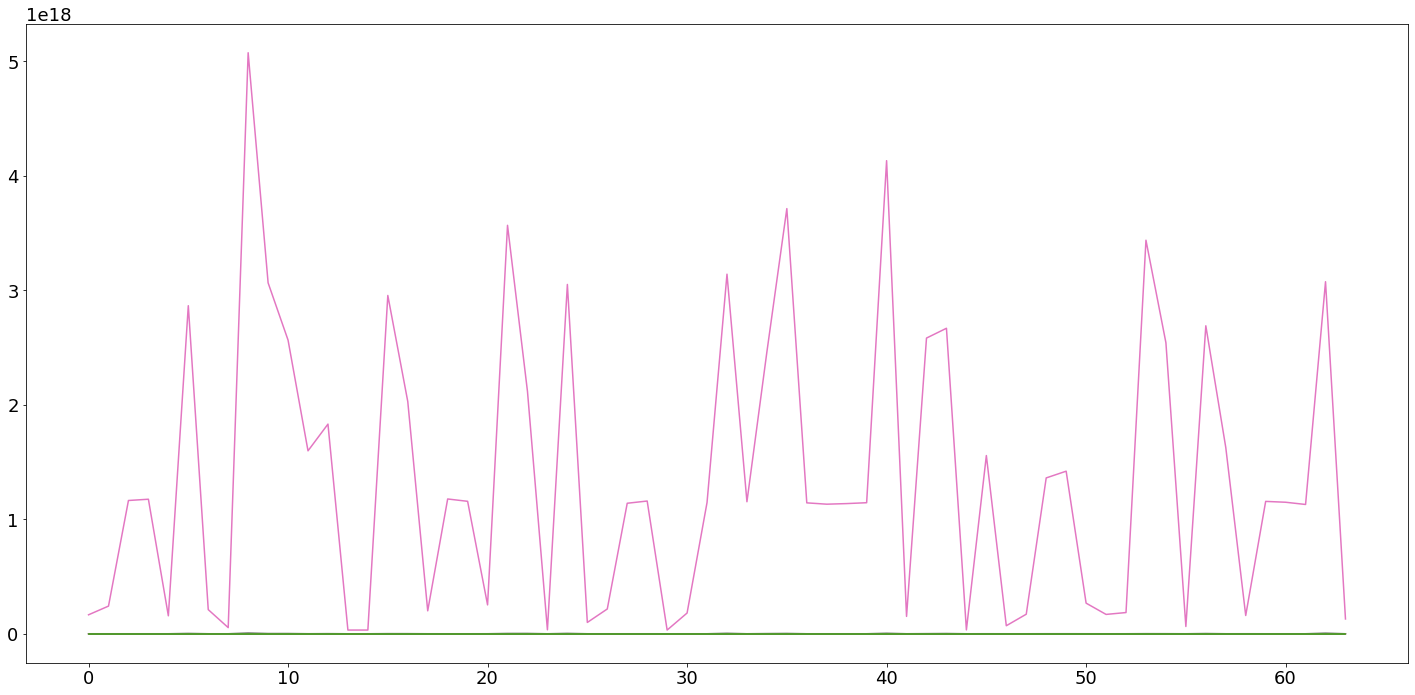

In [29]:
plt.plot(X_test)

In [30]:
low = []
med = [] 
high = []

y_low = []
y_med = []
y_high = []
for i in range(X_test.shape[0]):
    if X_test[i] >-20:
        high.append(X_test[i])
        y_high.append(y_test[i])
    elif X_test[i]<-20 and X_test[i]>-26.5:
        med.append(X_test[i])
        y_med.append(y_test[i])
    else:
        low.append(X_test[i])
        y_low.append(y_test[i])


print(X_test.shape[0],len(low), len(y_low)) 
low_pred = reg.predict(low)
med_pred = reg.predict(med)
high_pred = reg.predict(high)


# for i in range(len(low)):
#     low[i] = low[i][0]

    
# low = np.array(low)
# med = np.array(med)
# high = np.array(high)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
low = np.absolute(low_pred-y_low)
med = np.absolute(med_pred-y_med)
high = np.absolute(high_pred-y_high)
med = med[12:22]

In [ ]:

low_mean = np.mean(low)
med_mean = np.mean(med)
high_mean = np.mean(high)


# low_mean2 = np.mean(low2)
# med_mean2 = np.mean(med2)
# high_mean2 = np.mean(high2)

# Calculate the standard deviation
low_std = np.std(low)
med_std = np.std(med)
high_std = np.std(high)

# low_std2 = np.std(low2)
# med_std2 = np.std(med2)
# high_std2 = np.std(high2)


# Define labels, positions, bar heights and error bar heights
labels = ['slow talking', 'medium talking', 'loud talking']
x_pos = np.arange(len(labels))
CTEs = [low_mean, med_mean, high_mean]
# CTEs2 = [low_mean2, med_mean2, high_mean2]
error = [low_std, med_std, high_std]
# error2 = [low_std2, med_std2, high_std2]

# Build the plot
fig, ax = plt.subplots(figsize=(9,7))
ax.bar(x_pos, CTEs,
       yerr=error,
       width=0.4,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10,label="Distance 70 inches")

# ax.bar(x_pos+0.2, CTEs2,
#        yerr=error2,
#        width=0.4,
#        align='center',
#        alpha=0.5,
#        ecolor='black',
#        capsize=10,
#       label="Distance 120 inches")
# ax.legend()
ax.set_ylabel('Absolute error(decibels)')
# ax.set_xlabel('Distance 70 inch')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('AP_error_bar.png')
plt.show()

In [ ]:
low

In [ ]:
med

In [ ]:
high

In [ ]:
plt.plot(low)
plt.plot(med)
plt.plot(high)